### Setting directory

In [46]:
%cd C:\Users\Áron\Desktop\Courses\csgo-ai-competition-master
%pwd

C:\Users\Áron\Desktop\Courses\csgo-ai-competition-master


'C:\\Users\\Áron\\Desktop\\Courses\\csgo-ai-competition-master'

### Imports


In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth = 120)
from torch.utils.tensorboard import SummaryWriter
from itertools import product
from collections import OrderedDict, namedtuple
from random import shuffle
import time
import tensorflow as tf
import pandas as pd
from IPython.display import display, clear_output
import json
from sklearn.model_selection import train_test_split

print(torch.__version__)

D:\anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWarning: Passing (type, 1) or '1type' 

1.5.0


In [48]:
train_set = torchvision.datasets.FashionMNIST(
            root="./data/FashionMNIST",
            train = True,
            download = True,
            transform = transforms.Compose([
                transforms.ToTensor()
            ]))

### Buliding model

In [49]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size= 5)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size= 5)
        
        self.fc1 = nn.Linear(in_features = 12*4*4, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 60)
        self.out = nn.Linear(in_features = 60, out_features = 10)
        
    def forward(self, t):
        t = t
        
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        
        
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        
        t= self.fc2(t)
        t = F.relu(t)
        
        t = self.out(t)
        #t = F.softmax(t, dim = 1)
        
        
        return t

### Training with parameter tuning

In [50]:
class RunBuilder():
    @staticmethod #so dont have to initialize class or function
    def get_runs(parameters):
        Run = namedtuple("Run", parameters.keys())
        runs = []
        
        for v in product(*parameters.values()):
            runs.append(Run(*v))
        return runs

In [64]:
class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.Network = None
        self.loader = None
        self.tb = None
        
    def begin_run(self, run, network, loader):
        self.run_start_time = time.time()
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment = f"-{run}")
        
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image("images", grid)
        self.tb.add_graph(self.network, images.to(getattr(run, "device", "cpu")))
        
        
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0
        
    def get_device(self):
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            print("Running on the GPU")
        else:
            device = torch.device("cpu")
            print("Running on the CPU") 
        
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
        
        self.tb.add_scalar("Loss", loss, self.epoch_count)
        self.tb.add_scalar("Accuracy", accuracy, self.epoch_count)
        
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f"{name}.grad", param.grad, self.epoch_count)
            
        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient = "columns")
        
        clear_output(wait=True)
        display(df)
        
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * self.loader.batch_size

    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self.get_num_correct(preds, labels)
        
    def get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data, orient='columns'
        ).to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [68]:
m = RunManager()

parameters = OrderedDict(
        lr = [0.01],
        batch_size = [100, 1000],
        num_workers = [1],
        device = ["cuda"])

for run in RunBuilder.get_runs(parameters):
    
    device = torch.device(run.device)
    network = Network().to(device)
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size, num_workers = run.num_workers)
    optimizer = optim.Adam(network.parameters(), lr = run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(10):
        m.begin_epoch()
        for batch in loader: #Get bach
            images = batch[0].to(device)
            labels = batch[1].to(device)
            

            preds = network(images) #Pas batch
            loss = F.cross_entropy(preds,labels) #Get loss

            optimizer.zero_grad() #Zero the gradients after each batch
            loss.backward() #calculate gradients
            optimizer.step() #update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        
        m.end_epoch()
    m.end_run()
m.save("res")


        

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device
0,1,1,0.546733,0.794750,6.861096,8.063316,0.01,100,1,cuda
1,1,2,0.371484,0.861983,7.688418,15.860315,0.01,100,1,cuda
2,1,3,0.344594,0.872467,7.906845,23.892821,0.01,100,1,cuda
3,1,4,0.328807,0.879483,7.450066,31.444616,0.01,100,1,cuda
4,1,5,0.323007,0.880800,6.895581,38.431953,0.01,100,1,cuda
5,1,6,0.309655,0.886450,6.854389,45.390035,0.01,100,1,cuda
6,1,7,0.311950,0.884033,6.848727,52.330516,0.01,100,1,cuda
7,1,8,0.302049,0.888967,6.916569,59.357741,0.01,100,1,cuda
8,1,9,0.304380,0.887400,6.889009,66.339502,0.01,100,1,cuda
9,1,10,0.299654,0.889383,6.892581,73.329820,0.01,100,1,cuda


## Evaluating 

#### Making the  confusion matrix

In [ ]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds),dim = 0)
    return all_preds

In [ ]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size = 10000)
train_preds = get_all_preds(network, prediction_loader)

In [81]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size = 10000)
    train_preds = get_all_preds(network, prediction_loader)

In [82]:
stacked = torch.stack(
    (
        train_set.targets,
        train_preds.argmax(dim = 1)
    ),
    dim = 1
)

In [83]:
cm = torch.zeros(10,10, dtype = torch.int32)

In [84]:
for item in stacked:
    j, k = item.tolist()
    cm[j, k] = cm[j, k] +1

#### Plotting confusion matrix 

In [85]:
from plot_cm import plot_confusion_matrix

Confusion matrix, without normalization
tensor([[5308,    1,   92,   74,    3,    1,  506,    0,   15,    0],
        [  28, 5864,    2,   77,    5,    2,   13,    0,    9,    0],
        [  37,    1, 5125,   51,  370,    0,  405,    0,   11,    0],
        [ 221,   44,   20, 5446,  152,    3,  102,    0,   12,    0],
        [   7,    1,  735,  228, 4267,    1,  751,    0,   10,    0],
        [   0,    1,    0,    1,    0, 5930,    0,   41,    7,   20],
        [ 945,    1,  531,  117,  154,    0, 4206,    0,   46,    0],
        [   0,    0,    0,    0,    0,  124,    0, 5777,    8,   91],
        [  14,    1,    9,   13,    3,    5,   47,    1, 5907,    0],
        [   0,    0,    0,    0,    0,   62,    0,  230,    1, 5707]], dtype=torch.int32)


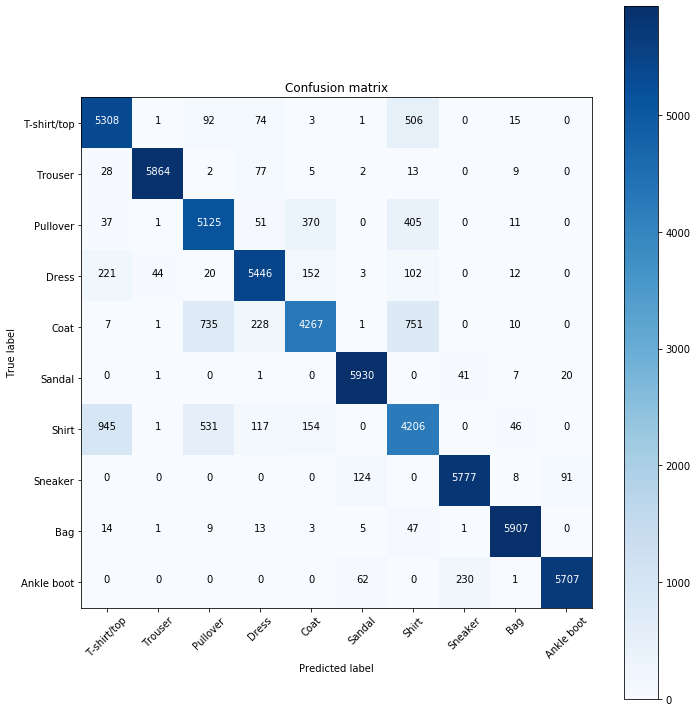

In [86]:
names = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)